In [1]:
import datetime as dt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from recsys4daos.utils import notebooks as nbutils
import paths

sns.set_theme(rc = {
})
sns.set_context("paper")

# Paper column width in inches
PAPER_COL_WIDTH = 3.5

original = plt.rcParamsDefault['figure.figsize']
ratio = original[0] / original[1]
print(f"Original size: {original}, Ratio: {ratio}")
plt.rcParams['figure.figsize'] = (PAPER_COL_WIDTH, PAPER_COL_WIDTH/ratio)
print("New size:", plt.rcParams['figure.figsize'])

# In acmart, 9pt is the default
# And 7pt for \footnotesize
# plt.rcParams['font.size'] = 7,

# The following are already relatively defined
# plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']

Original size: [6.4, 4.8], Ratio: 1.3333333333333335
New size: [3.5, 2.6249999999999996]


In [2]:
ORG_NAME = 'Decentraland'
SPLITS_FREQ: str = None # Not used in this notebook
SPLITS_NORMALIZE: bool = None # Not used in this notebook
LAST_FOLDS: int = 0 # Not used in this notebook

In [3]:
# Parameters
EXECUTION_ID = "2024-07-01"
ORG_NAME = "Decentraland"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True


In [4]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2213 entries, 0 to 2212
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2213 non-null   object        
 1   author             2213 non-null   object        
 2   date               2213 non-null   datetime64[us]
 3   start              2213 non-null   datetime64[us]
 4   end                2213 non-null   datetime64[us]
 5   platform_proposal  2213 non-null   object        
dtypes: datetime64[us](3), object(3)
memory usage: 103.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        116560 non-null  object        
 1   proposal  116560 non-null  object        
 2   voter     116560 non-null  object        
 3   date      116560 non-null  datetime64[

## Proposals and time

### How much time does each proposal take

7 days     1327
14 days     473
5 days      391
10 days      17
28 days       5
Name: count, dtype: int64
7 days     0.599638
14 days    0.213737
5 days     0.176683
10 days    0.007682
28 days    0.002259
Name: count, dtype: float64


count                      2213
mean     8 days 05:07:07.835517
std      3 days 06:47:32.369224
min             5 days 00:00:00
25%             7 days 00:00:00
50%             7 days 00:00:00
75%             7 days 00:00:00
max            28 days 00:00:00
dtype: object

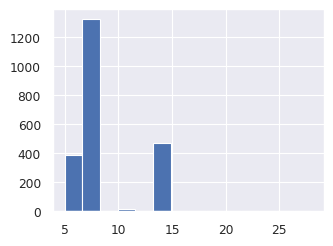

In [5]:
# Original: Cell [5] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb

delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
print(vc := delta.value_counts())
print(vc / len(delta))
delta.describe()

#### Avg. proposal length in time

<Axes: xlabel='date'>

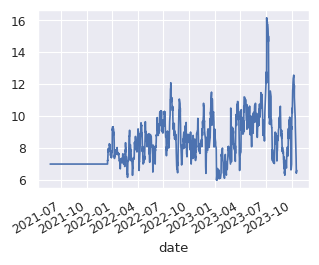

In [6]:
# Original: Cell [6] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
ROLLING_LENGTH = '7d'

_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling(ROLLING_LENGTH).mean().plot()

## How many proposals are created per week

<Figure size 350x262.5 with 0 Axes>

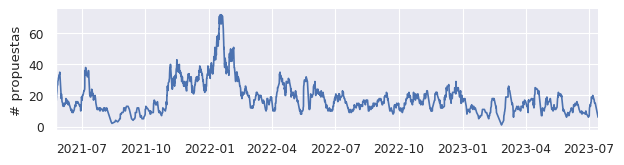

In [7]:
WINDOW_SIZE = dt.timedelta(days=7)

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)

sns.despine()

## What day of the week are proposals created

start
Tuesday      386
Monday       385
Wednesday    366
Thursday     338
Friday       283
Saturday     233
Sunday       222
Name: count, dtype: int64


/tmp/ipykernel_1056811/3307774390.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

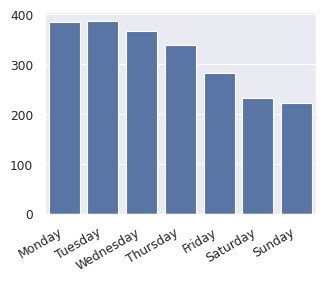

In [8]:
# Original: Cell [7] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
DAYS_OF_WEEK_ENG = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfp['start'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# proposals')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, 'proposals_dow.pdf')

## What day of the week are proposals voted

date
Tuesday      17573
Friday       17101
Monday       17059
Thursday     16952
Wednesday    16784
Saturday     16496
Sunday       14595
Name: count, dtype: int64


/tmp/ipykernel_1056811/3643726510.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

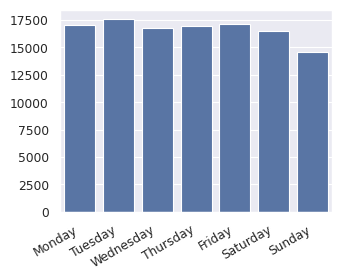

In [9]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfv['date'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# votes')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, "votes_dow.pdf")

## In which moment of the proposal lifetime are votes cast

time remaining                                                    \
                 count      mean       std       min       25%       50%   
delta                                                                      
10 days          346.0  0.693311  0.297104  0.000860  0.518275  0.805131   
14 days        38358.0  0.743704  0.275562  0.000007  0.602668  0.862094   
5 days         25446.0  0.681070  0.282013  0.000028  0.486466  0.779140   
7 days         52410.0  0.710870  0.278719  0.000017  0.545402  0.817386   

                             
              75%       max  
delta                        
10 days  0.945914  0.999681  
14 days  0.957256  0.999992  
5 days   0.913594  0.999963  
7 days   0.935893  0.999985

52151 (44.74%) of the votes are being cast on the first 14.29% of rel time
109658 (94.08%) of the votes are being cast on the first 85.71% of rel time


Cannot show ipywidgets in text

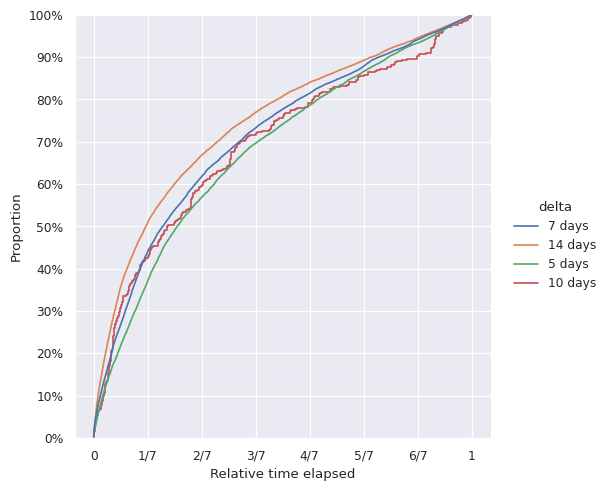

In [10]:
from matplotlib import ticker

PLOT_HUE = True

_dfv = dfv[['proposal', 'date']].merge(dfp[['id', 'start', 'end']], left_on='proposal', right_on='id').sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
_dfv['delta'] = (_dfv['end'] - _dfv['start']).astype(str)
_dfv['time remaining'] = 1 - _dfv['date_rel']

display(_dfv.groupby('delta')[['time remaining']].describe())

for t in [1/7, 6/7]:
    first_day = (_dfv['date_rel'] < t)
    print(f"{first_day.sum()} ({first_day.mean()*100:.2f}%) of the votes are being cast on the first {t*100:.2f}% of rel time")
    
fg = sns.displot(_dfv, x='date_rel', kind='ecdf', hue='delta' if PLOT_HUE else None)
# fg.ax.xaxis.set_major_locator(ticker.MultipleLocator(1/7))

fg.ax.yaxis.set_major_locator(ticker.MultipleLocator(1/10))
fg.ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
fg.ax.set_xticks(np.arange(8)/7)
fg.ax.set_xticklabels(["0"] + [f"{x}/7" for x in range(1,7)] + ["1"])
fg.ax.set_xlabel('Relative time elapsed');

nbutils.download_matplotlib(fg, f"votes_in_time{'-color' if PLOT_HUE else ''}.pdf")

## Histograms

### Votes per user

count    7268.000000
mean       16.037424
std        46.115318
min         1.000000
10%         1.000000
15%         1.000000
50%         3.000000
90%        36.000000
95%        64.000000
99%       205.330000
max       885.000000
dtype: float64
2025 voters (27.86%) have voted more than 10 times
197 voters (2.71%) have voted more than 100 times


Cannot show ipywidgets in text

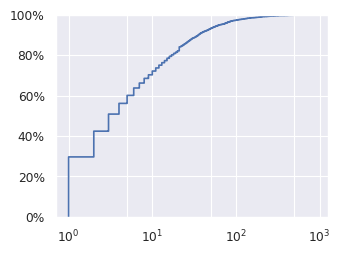

In [11]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print(_toplot.describe(percentiles=[.1, .15, .5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votes')
plt.ylabel('% voters')

_times_voted = [10, 100]
for t in _times_voted:
    _nusers = (_toplot > t).sum()
    print(f"{_nusers} voters ({_nusers/len(_toplot)*100:.2f}%) have voted more than {t} times")

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpv.pdf")

### Votes per proposal

count    1942.000000
mean       60.020597
std        63.080051
min         1.000000
10%         9.000000
15%        11.000000
20%        14.000000
25%        16.000000
50%        36.000000
75%        82.000000
90%       146.000000
95%       192.950000
99%       291.360000
max       385.000000
dtype: float64
Total votes: 116560
1677 proposals (86.35%) have more than 10 votes
553 proposals (28.48%) have more than 72 votes
540 proposals (27.81%) have more than 73 votes
367 proposals (18.90%) have more than 100 votes


Cannot show ipywidgets in text

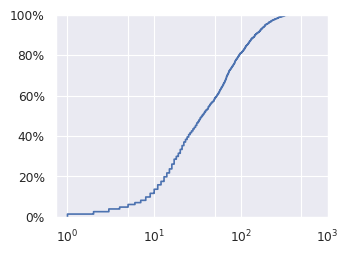

In [12]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.1, .15, .20, .25, .5,.75,.9, .95, .99]))

print("Total votes:", _toplot.sum())
_times_voted = [10, 72, 73, 100]
for t in _times_voted:
    _nprops = (_toplot > t).sum()
    print(f"{_nprops} proposals ({_nprops/len(_toplot)*100:.2f}%) have more than {t} votes")

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.xlabel('# votes')
plt.ylabel('% proposals')

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpp.pdf")